In [80]:
from __future__ import print_function
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np

#import astropy.io.fits as pyfits
import pyfits, time, itertools, random, os, sys, glob, re

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
#import seaborn as sns; sns.set()

%matplotlib inline

## Multiple Spectrographs (Updated July 5th)

In [81]:
star_names = np.genfromtxt("star_names.txt", dtype='str')

short_stars_rv = np.genfromtxt("RVs.txt", usecols=1, skip_header=2)
lit_ha = np.genfromtxt("RVs.txt", usecols=2, skip_header=2)
lit_ha_err = np.genfromtxt("RVs.txt", usecols=3, skip_header=2)
#print(short_stars_rv)

In [82]:
stars_EW_avgs = []
stars_EW_avgs_err = []

#star_names = ["2MASSJ02543316-5108313"]
#star_names = ["GJ871.1A"]
#star_names = ["GJ176"]

for j in range(len(star_names)):
    
    print(star_names[j])

    spectrum = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(len(spectrum))
    #print(spectrum)

    all_ew = []
    all_err_ew = []

    for i in range(len(spectrum)):
        #print(spectrum[i])
        
        if "ADP" in spectrum[i]:
            hdu = pyfits.open(spectrum[i])

            """
            target = hdu[1].header["OBJECT "]
            #print(target)
            if target[2:] != star_names[j][2:]: 
                print("Missclassified Spectrum: ", spectrum[i], "Object actually: ", target)
            """

            wave = hdu[1].data[0][0]
            flux = hdu[1].data[0][1]
            #err = np.nan_to_num(hdu[1].data[0][2])
            #print("HARPS Error Array: ", err)

            #speed of light, target star RV, H-alpha in meters per second
            c = 299792458e10
            RV = short_stars_rv[j] * (10 ** 13)
            Ha = 6562.8e-10

            #accounting for target star RV conversion in angstroms
            #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
            #wave = wave - (wave * RV / c)
            wave = wave / (1 + RV / c)

            #fnding mean continuum flux
            idx_cont = ((wave > 6500) & (wave < 6550)) | ((wave > 6575) & (wave < 6625))
            
            #print(wave[idx_cont])
            
            #print(len(idx_cont[0]))
            
            #HARPS OR UVES TARGET SPECTRA IN PROPER RANGE
            if len(idx_cont[idx_cont==True]) != 0:
                if (np.min(wave)>6500 or np.max(wave)<6625):
                    print("Spectrum range not inclusive of all regions: ", spectrum[i])
                        
                    ew = "nan"
                    err_ew = "nan"

                    all_ew.append(ew)
                    all_err_ew.append(err_ew)
                
                else:
                    sub_cont = flux[idx_cont]
                    mean_cont = np.mean(sub_cont)
                    #squared_diffs = np.array([(each_flux-mean_cont)**2 for each_flux in sub_cont])
                    squared_diffs = (sub_cont-mean_cont)**2
                    err_cont = np.sqrt(np.sum(squared_diffs)/len(sub_cont))
                    #print("Mean Continuum Flux (Fc): ", mean_cont)
                    #print("Mean Continuum Flux STD: ", err_cont)

                    #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
                    idx_wave = np.array(np.where((wave > 6558.8) & (wave < 6566.8)))
                    #err_flux = err[idx_wave]
                    delta_wave = (np.max(wave)-np.min(wave)) / len(wave) #pixel width, assumed to be same for all 
                    sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
                    ew = np.sum(sub_flux)
                    #print("Equivalent Width (Angstroms): ", ew)

                    #error analysis of equivalent width -- note: assuming pixel width error is negligible
                    x = flux[idx_wave]
                    y = mean_cont
                    z = delta_wave
                    #func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
                    func_var = np.array([(err_cont**2)*((x[g]*z/y**2)**2) for g in range(len(sub_flux))])
                    err_ew = np.sqrt(np.sum(func_var))
                    #print("Equivalent Width VAR: ", err_ew)

                    all_ew.append(ew)
                    all_err_ew.append(err_ew)
                    
                    """#plt.figure(figsize=(10,6))
                    plt.plot(wave,flux, color="cornflowerblue")
                    plt.xlim(6558.8,6566.8)
                    #plt.xlim(6500,6600)
                    plt.ticklabel_format(useOffset=False)
                    plt.show()"""
    
            #UVES TARGET SPECTRA NOT IN PROPER RANGE
            else:
                ew = "nan"
                err_ew = "nan"

                all_ew.append(ew)
                all_err_ew.append(err_ew)
        
        #HIRES TARGET SPECTRA
        if "HI" in spectrum[i]:
            ew = "nan"
            err_ew = "nan"
            all_ew.append(ew)
            all_err_ew.append(err_ew)
    
    #print(all_ew)

    output = np.column_stack((np.nan_to_num(np.array(all_ew).astype("float")), 
                         np.nan_to_num(np.array(all_err_ew).astype("float"))))
    np.savetxt("Results/%s_spectra_halpha.txt" % star_names[j], output)
            
    #stars_EW_avgs.append(np.nanmean(np.array(all_ew).astype("float"))) #np.nanmean takes average while ignoring nan
    #stars_EW_avgs_err.append(np.nanstd(np.array(all_ew).astype("float"), ddof=1))
    
    non_nan = np.where(np.logical_not(np.isnan(np.array(all_ew).astype("float"))))[0]
    all_ew = np.array(all_ew).astype("float")
    all_err_ew = np.array(all_err_ew).astype("float")
    
    if len(non_nan) != 0:
        stars_EW_avgs.append(np.average(all_ew[non_nan], weights=1/((all_err_ew[non_nan])**2))) #np.nanmean takes average while ignoring nan
        stars_EW_avgs_err.append(np.sqrt(1/np.sum(1/((all_err_ew[non_nan])**2))))
        print("Average EW: ", np.average(all_ew[non_nan], weights=1/((all_err_ew[non_nan])**2)))
        print("Error: ", np.sqrt(1/np.sum(1/((all_err_ew[non_nan])**2))))
                                  
    elif len(spectrum) == 0 or star_names[j]=="GJ644A":
        stars_EW_avgs.append(lit_ha[j])
        stars_EW_avgs_err.append(lit_ha_err[j])
        print("Average EW (from literature): ", lit_ha[j])
        print("Error (from literature): ", lit_ha_err[j])
        
    else:
        stars_EW_avgs.append("nan")
        stars_EW_avgs_err.append("nan")
        print("Average EW: nan")
        print("Error: nan")
    
print("Star names: ", star_names)
print("EW averages for each star: ", stars_EW_avgs)
#print("EW error total: ", np.std(all_ew)/np.sqrt(len(all_ew)))

GJ176
Average EW:  0.157001495436
Error:  0.00356810227686
GJ667C
Average EW:  0.229068666468
Error:  0.00204027221145
GJ581
Average EW:  0.0573740792592
Error:  0.00822129651322
GJ1214
Average EW:  -0.0170800707857
Error:  0.00708319588111
GJ832
Average EW:  0.234815985357
Error:  0.00384808473815
GJ876
Average EW:  0.047923894773
Error:  0.00382836416256
GJ436
Average EW:  0.181283857146
Error:  0.00312497716505
GJ628
Average EW:  0.141458823044
Error:  0.00332855912662
GJ887
Average EW:  0.270054197668
Error:  0.00173474192404
GJ1061
Spectrum range not inclusive of all regions:  Spectra/GJ1061/ADP.2013-09-28T09:05:29.783.fits
Spectrum range not inclusive of all regions:  Spectra/GJ1061/ADP.2013-09-28T09:06:58.660.fits
Spectrum range not inclusive of all regions:  Spectra/GJ1061/ADP.2013-09-28T09:06:58.713.fits
Spectrum range not inclusive of all regions:  Spectra/GJ1061/ADP.2013-09-28T09:09:33.863.fits
Spectrum range not inclusive of all regions:  Spectra/GJ1061/ADP.2013-09-28T09:13

/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater
/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in less


Average EW: nan
Error: nan
2MASSJ04483062+1623187
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04235911+1643178
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04251456+1858250
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04202761+1853499
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04172811+1454038
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ02564122+3522346
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ03553690+2118482
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ03555715+1825564
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ03581434+1237408
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04004493+1354227
Average EW (from literature):  nan
Error (from literature):  nan
2MASSJ04062060+1901391
Average EW (from literature):  nan
Error (from literature):  nan
2MASS

In [83]:
output = np.column_stack((np.nan_to_num(np.array(stars_EW_avgs).astype("float")), 
                         np.nan_to_num(np.array(stars_EW_avgs_err).astype("float"))))
np.savetxt("Results/halpha.txt", output)

6562.67843606 6562.92156394


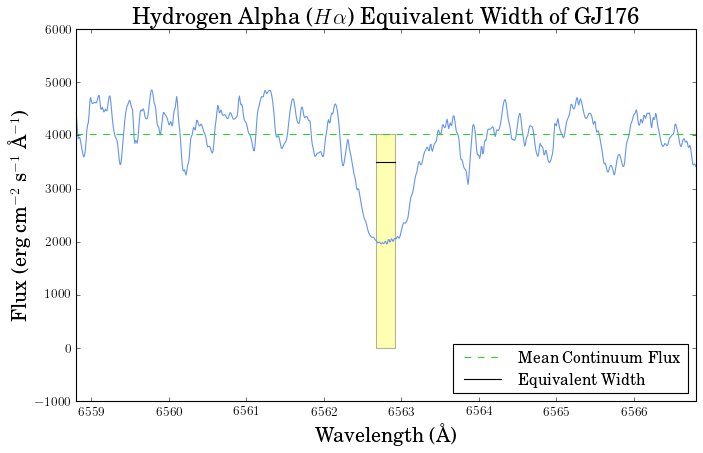

In [11]:
print(6562.8-0.24312788/2, 6562.8+0.24312788/2)
x=[6562.8-0.24312788/2, 6562.8+0.24312788/2, 6562.8+0.24312788/2, 6562.8-0.24312788/2]
y=[mean_cont, mean_cont, 0, 0]

plt.figure(figsize=(10,6))
plt.plot(wave,flux, color="cornflowerblue")
plt.xlim(6558.8,6566.8)
#plt.xlim(6495,6630)
#plt.ylim(0,6000)
#plt.ylim(0,5500)
#plt.axvline(6562.8, color="limegreen", linestyle="--")
#plt.text(6563, 5200, r"$H\alpha = 6562.8")
plt.axhline(mean_cont, color="limegreen", linestyle="--", label= "Mean Continuum Flux")
#plt.plot((6500, 6550), (mean_cont, mean_cont), linewidth=2, color = 'limegreen', linestyle="--", label= "Mean Continuum Flux")
#plt.plot((6575, 6625), (mean_cont, mean_cont), linewidth=2, color = 'limegreen', linestyle="--")
#plt.plot((6500, 6500), (0, mean_cont), linewidth=2, color = 'limegreen', linestyle="--")
#plt.plot((6550, 6550), (0, mean_cont), linewidth=2, color = 'limegreen', linestyle="--")
#plt.plot((6575, 6575), (0, mean_cont), linewidth=2, color = 'limegreen', linestyle="--")
#plt.plot((6625, 6625), (0, mean_cont), linewidth=2, color = 'limegreen', linestyle="--")
plt.plot((6562.8-0.24312788/2, 6562.8+0.24312788/2), (3500, 3500), linewidth=1, color = 'black', label="Equivalent Width")
#plt.arrow(6562.8-0.24312788/2, 1200, 0.24312788, 0, color = 'black', label="Equivalent Width")
plt.fill(x, y, facecolor="yellow", alpha=0.3)
#plt.text(6562.8+0.24312788, 1200, r"$H\alpha$ Equivalent Width")
plt.xlabel(r"Wavelength (\AA)", fontsize=18)
plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)", fontsize=18)
plt.ticklabel_format(useOffset=False)
plt.title(r"Hydrogen Alpha ($H\alpha$) Equivalent Width of GJ176", fontsize=20)
plt.legend(loc="lower right", fontsize=14)
#plt.savefig("Comparisons/POSTER_Halpha_example.png")
plt.show()

# BELOW IS TEST/OLDER CODE

# HARPS AND HIRES (before coadding the spectra!)

In [ ]:
stars_EW_avgs = []
stars_EW_avgs_err = []

#star_names = ["GJ191"]

for j in range(len(star_names)):
    
    print(star_names[j])

    spectrum = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum[0])
    #print(spectrum)

    all_ew = []
    all_err_ew = []

    for i in range(len(spectrum)):
        
        if "ADP" in spectrum[i]:
            hdu = pyfits.open(spectrum[i])

            """
            target = hdu[1].header["OBJECT "]
            #print(target)
            if target[2:] != star_names[j][2:]: 
                print("Missclassified Spectrum: ", spectrum[i], "Object actually: ", target)
            """

            wave = hdu[1].data[0][0]
            flux = hdu[1].data[0][1]
            err = np.nan_to_num(hdu[1].data[0][2])
            #print("HARPS Error Array: ", err)

            #speed of light, target star RV, H-alpha in meters per second
            c = 299792458e10
            RV = short_stars_rv[j] * (10 ** 13)
            Ha = 6562.8e-10

            #accounting for target star RV conversion in angstroms
            #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
            #wave = wave - (wave * RV / c)
            wave = wave / (1 + RV / c)

            #fnding mean continuum flux
            idx_cont = np.where(((wave > 6500) & (wave < 6550))|((wave > 6575) & (wave < 6625)))
            #print(wave[idx_cont])
            
            #HARPS OR UVES TARGET SPECTRA IN PROPER RANGE
            if len(wave[idx_cont]) != 0:
                if (np.min(wave)>6500 or np.max(wave)<6625):
                    print("Spectrum range not inclusive of all regions: ", spectrum[i])
                        
                    ew = "nan"
                    err_ew = "nan"

                    all_ew.append(ew)
                    all_err_ew.append(err_ew)
                
                else:
                    sub_cont = flux[idx_cont]
                    err_cont = np.std(sub_cont)
                    mean_cont = np.mean(sub_cont)
                    #print("Mean Continuum Flux (Fc): ", mean_cont)
                    #print("Mean Continuum Flux STD: ", err_cont)

                    #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
                    idx_wave = np.array(np.where((wave > 6558.8) & (wave < 6566.8)))
                    err_flux = err[idx_wave]
                    delta_wave = (np.max(wave)-np.min(wave)) / len(wave) #pixel width, assumed to be same for all 
                    sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
                    ew = np.sum(sub_flux)
                    #print("Equivalent Width (Angstroms): ", ew)

                    #error analysis of equivalent width -- note: assuming pixel width error is negligible
                    x = flux[idx_wave]
                    y = mean_cont
                    z = delta_wave
                    func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
                    err_ew = np.sqrt(np.sum(func_var))
                    #print("Equivalent Width VAR: ", err_ew)

                    all_ew.append(ew)
                    all_err_ew.append(err_ew)
    
            #UVES TARGET SPECTRA NOT IN PROPER RANGE
            else:
                ew = "nan"
                err_ew = "nan"

                all_ew.append(ew)
                all_err_ew.append(err_ew)
        
        #HIRES TARGET SPECTRA
        if "HI" in spectrum[i]:
            ew = "nan"
            err_ew = "nan"
            all_ew.append(ew)
            all_err_ew.append(err_ew)
    
    #print(all_ew)
            
    #stars_EW_avgs.append(np.nanmean(np.array(all_ew).astype("float"))) #np.nanmean takes average while ignoring nan
    #stars_EW_avgs_err.append(np.nanstd(np.array(all_ew).astype("float"), ddof=1))
    
    non_nan = np.where(np.logical_not(np.isnan(np.array(all_ew).astype("float"))))[0]
    all_ew = np.array(all_ew).astype("float")
    all_err_ew = np.array(all_err_ew).astype("float")
    
    if len(non_nan) != 0:
        stars_EW_avgs.append(np.average(all_ew[non_nan], weights=1/((all_err_ew[non_nan])**2))) #np.nanmean takes average while ignoring nan
        stars_EW_avgs_err.append(1/np.sum(1/((all_err_ew[non_nan])**2)))
        print("Average EW: ", np.average(all_ew[non_nan], weights=1/((all_err_ew[non_nan])**2)))
        print("Error: ", 1/np.sum(1/((all_err_ew[non_nan])**2)))
    else:
        stars_EW_avgs.append("nan")
        stars_EW_avgs_err.append("nan")
        print("Average EW: nan")
        print("Error: nan")
    
print("Star names: ", star_names)
print("EW averages for each star: ", stars_EW_avgs)
#print("EW error total: ", np.std(all_ew)/np.sqrt(len(all_ew)))

# HARPS ONLY

In [ ]:
stars_EW_avgs = []
stars_EW_avgs_err = []

star_names = ["GJ176"]

for j in range(len(star_names)):
    
    print(star_names[j])

    spectrum = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)

    all_ew = []
    all_err_ew = []

    for i in range(len(spectrum)):
        hdu = pyfits.open(spectrum[i])
        
        """
        target = hdu[1].header["OBJECT "]
        #print(target)
        if target[2:] != star_names[j][2:]: 
            print("Missclassified Spectrum: ", spectrum[i], "Object actually: ", target)
        """

        wave = hdu[1].data[0][0]
        flux = hdu[1].data[0][1]
        err = np.nan_to_num(hdu[1].data[0][2])
        #print("HARPS Error Array: ", err)

        #speed of light, target star RV, H-alpha in meters per second
        c = 299792458e10
        RV = short_stars_rv[j] * (10 ** 13)
        Ha = 6562.8e-10

        #accounting for target star RV conversion in angstroms
        #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
        wave = wave - (wave * RV / c)
        
        #fnding mean continuum flux
        idx_cont = np.where(((wave > 6500) & (wave < 6550))|((wave > 6575) & (wave < 6625)))
        sub_cont = flux[idx_cont]
        err_cont = np.std(sub_cont)
        mean_cont = np.mean(sub_cont)
        #print("Mean Continuum Flux (Fc): ", mean_cont)
        #print("Mean Continuum Flux STD: ", err_cont)

        #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
        idx_wave = np.array(np.where((wave > 6558.8) & (wave < 6566.8)))
        err_flux = err[idx_wave]
        delta_wave = wave[idx_wave[0][400]]-wave[idx_wave[0][399]] #pixel width, assumed to be same for all 
        sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
        ew = np.sum(sub_flux)
        #print("Equivalent Width (Angstroms): ", ew)

        #error analysis of equivalent width -- note: assuming pixel width error is negligible
        x = flux[idx_wave]
        y = mean_cont
        z = delta_wave
        func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
        err_ew = np.sqrt(np.sum(func_var))
        #print("Equivalent Width VAR: ", err_ew)

        all_ew.append(ew)
        all_err_ew.append(err_ew)
            
    stars_EW_avgs.append(np.mean(all_ew))
    stars_EW_avgs_err.append(np.std(all_ew, ddof=1)) #used
    
    plt.figure()
    plt.plot(wave,flux)
    plt.xlim(6558.8,6566.8)
    plt.axvline(6562.8)
    plt.show()

print("Star names: ", star_names)
print("EW averages for each star: ", stars_EW_avgs)
#print("EW error total: ", np.std(all_ew)/np.sqrt(len(all_ew)))

In [ ]:
plt.plot(wave,flux)
plt.xlim(6558.8,6566.8)
plt.axvline(6562.8 + 6562.8 * RV / c ) 

In [ ]:
output = np.column_stack((stars_EW_avgs, stars_EW_avgs_err))
np.savetxt("Results/short_halpha.txt", output)

# HIRES ONLY

## Note: just to figure out how this might work; HIRES does not seem to observe in the first H Alpha continuum region (6500-6550)

In [ ]:
stars_EW_avgs = []
stars_EW_avgs_err = []

star_names = ["HD173739"]
for j in range(len(star_names)):
    
    print(star_names[j])

    spectrum = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)

    all_ew = []
    all_err_ew = []

    for i in range(len(spectrum)):
        
        print(spectrum[i])

        V_file = glob.glob("%s/HI.*_1_03_flux.fits" % spectrum[i])
        HK_file = glob.glob("%s/HI.*_1_04_flux.fits" % spectrum[i])
        R_file = glob.glob("%s/HI.*_1_05_flux.fits" % spectrum[i])
        print(V_file)

        V_hdu = pyfits.open(V_file[0])
        HK_hdu = pyfits.open(HK_file[0])
        R_hdu = pyfits.open(R_file[0])

        #speed of light, target star RV, H-alpha in meters per second
        c = 299792458e10
        RV_conv = -1.07 * (10**13)
        #RV = short_stars_rv[j] * (10 ** 13)
        Ha = 6562.8e-10

        V_wave = V_hdu[1].data["wave"] - (V_hdu[1].data["wave"] * RV / c)
        V_flux = V_hdu[1].data["flux"]
        V_err = np.zeros(len(V_wave))
        
        HK_wave = HK_hdu[1].data["wave"] - (HK_hdu[1].data["wave"] * RV / c)
        HK_flux = HK_hdu[1].data["flux"]
        HK_err = np.zeros(len(HK_wave))
        
        R_wave = R_hdu[1].data["wave"] - (R_hdu[1].data["wave"] * RV / c)
        R_flux = R_hdu[1].data["flux"]
        R_err = np.zeros(len(R_wave))

        #fnding mean continuum flux
        idx_cont = np.where(((V_wave > 6500) & (V_wave < 6550))|((R_wave > 6575) & (R_wave < 6625)))
        sub_cont = flux[idx_cont]
        err_cont = np.std(sub_cont)
        mean_cont = np.mean(sub_cont)
        #print("Mean Continuum Flux (Fc): ", mean_cont)
        #print("Mean Continuum Flux STD: ", err_cont)

        #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
        idx_wave = np.array(np.where((HK_wave > 6558.8) & (HK_wave < 6566.8)))
        err_flux = err[idx_wave]
        delta_wave = HK_wave[idx_wave[0][400]]-HK_wave[idx_wave[0][399]] #pixel width, assumed to be same for all 
        sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
        ew = np.sum(sub_flux)
        #print("Equivalent Width (Angstroms): ", ew)

        #error analysis of equivalent width -- note: assuming pixel width error is negligible
        x = flux[idx_wave]
        y = mean_cont
        z = delta_wave
        func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
        err_ew = np.sqrt(np.sum(func_var))

        all_ew.append(ew)
        all_err_ew.append(err_ew)

    stars_EW_avgs.append(np.mean(all_ew))
    stars_EW_avgs_err.append(np.std(all_ew, ddof=1)) #used

plt.figure()
plt.plot(wave,flux)
plt.xlim(6558.8,6566.8)
plt.axvline(6562.8)
plt.show()

print("Star names: ", star_names)
print("EW averages for each star: ", stars_EW_avgs)
#print("EW error total: ", np.std(all_ew)/np.sqrt(len(all_ew)))

In [ ]:

        """i=1
        c = 299792458e10
        RV_conv = -1.07 * 10 ** 13 / c
        plt.figure(figsize=(16,4))
        for index in range(len(V_files)):
            row3 = V_files[index]
            hdu3 = pyfits.open(row3)
            wave3 = hdu3[1].data["wave"] - hdu3[1].data["wave"]*RV_conv
            #print fn
            #plt.text(hdu[1].data["wave"][0], hdu[1].data["flux"][0], i)
            plt.plot(hdu[1].data["wave"] - hdu[1].data['wave']*RV_conv,hdu[1].data['flux'])
            i=i+1

        #plt.xlim(3930,3940)
        plt.xlim(3880,4020)
        plt.ylim(0,20000)
        #plt.xlim(6500,6550)
        #plt.ylim(0,100000)
        #plt.axvline(6562.8)"""

        """
        target = hdu[1].header["OBJECT "]
        #print(target)
        if target[2:] != star_names[j][2:]: 
            print("Missclassified Spectrum: ", spectrum[i], "Object actually: ", target)
        """

# BELOW IS PRELIMINARY/TEST CODES

### Determining Optimal Width of H Alpha Range

In [ ]:
spectrum = sorted(glob.glob("Spectra/GJ176/*.fits"))
index = np.where(star_names == "GJ176")

lower = np.linspace(6558.8, 6562.75, 20)
upper = np.linspace(6566.8, 6562.85, 20)

stars_EW_avgs = []
stars_EW_avgs_err = []
 
for j in range(len(lower)):
    print("lower: ", lower[j], "upper: ", upper[j])
    
    all_ew = []
    all_err_ew = []

    for i in range(len(spectrum)):
            hdu = pyfits.open(spectrum[i])

            wave = hdu[1].data[0][0]
            flux = hdu[1].data[0][1]
            err = np.nan_to_num(hdu[1].data[0][2])
            #print("HARPS Error Array: ", err)

            #speed of light, target star RV, H-alpha in meters per second
            c = 299792458e10
            RV = short_stars_rv[index] * (10 ** 13)
            Ha = 6562.8e-10

            #accounting for target star RV conversion in angstroms
            #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
            wave = wave - (wave * RV / c)

            #fnding mean continuum flux
            idx_cont = np.where(((wave > 6500) & (wave < 6550))|((wave > 6575) & (wave < 6625)))
            sub_cont = flux[idx_cont]
            err_cont = np.std(sub_cont)
            mean_cont = np.mean(sub_cont)
            #print("Mean Continuum Flux (Fc): ", mean_cont)
            #print("Mean Continuum Flux STD: ", err_cont)

            #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
            idx_wave = np.array(np.where((wave > lower[j]) & (wave < upper[j])))
            err_flux = err[idx_wave]
            delta_wave = (np.max(wave[idx_wave])-np.min(wave[idx_wave])) / len(wave[idx_wave]) # average pixel width, assumed to be same for all 
            sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
            ew = np.sum(sub_flux)
            #print("Equivalent Width (Angstroms): ", ew)

            #error analysis of equivalent width -- note: assuming pixel width error is negligible
            x = flux[idx_wave]
            y = mean_cont
            z = delta_wave
            func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
            err_ew = np.sqrt(np.sum(func_var))
            #print("Equivalent Width VAR: ", err_ew)

            all_ew.append(ew)
            all_err_ew.append(err_ew)

    stars_EW_avgs.append(np.mean(all_ew))
    stars_EW_avgs_err.append(np.std(all_ew, ddof=1)) #used

plt.figure()
plt.plot(wave,flux)
plt.xlim(6558.8,6566.8)
plt.axvline(6562.8)
plt.show()

In [ ]:
print(stars_EW_avgs)
print(stars_EW_avgs_err)

plt.figure()
plt.plot(upper-lower, np.array(stars_EW_avgs)/np.array(stars_EW_avgs_err))
plt.xlabel("Width of H alpha Window")
plt.ylabel("Signal to noise")
#plt.xlim(6558.8,6566.8)
#plt.axvline(6562.8)
plt.show()

## One Star, One Spectrum

In [ ]:
hdu = pyfits.open("Spectra/GJ176/ADP.2014-09-16T11:03:58.527.fits")
hdu.info()


"""target = hdu[1].header["OBJECT "]
print(target)
if target != "GJ1061": 
    print("Missclassified Spectrum: Spectra/GJ1061/ADP.2014-09-17T11:22:21.777.fits; Object actually: ", target)"""

In [ ]:
hdu[1].header

In [ ]:
wave = hdu[1].data[0][0]
flux = hdu[1].data[0][1]
err = np.nan_to_num(hdu[1].data[0][2])
#plt.plot(wave,err)
print("HARPS Error Array: ", err)

In [ ]:
#speed of light, target star RV, H-alpha in meters per second
c = 299792458
RV = 26410
Ha = 6562.8e-10

#accounting for target star RV conversion in angstroms
#RV given in SIMBAD (note: HARPS already corrects for movement of earth)
RV_conv = (Ha * RV / c) * (10 ** 10)
new_Ha = 6562.8 + RV_conv

print(RV_conv)
print(new_Ha)

"""
#print(RV_conv)
sub = np.where((wave > 6558.8) & (wave < 6566.8))
find_min = np.argmin(flux[sub])
sub_wave = wave[sub]
find_wave_at_min = sub_wave[find_min]
print(find_wave_at_min)
RV_conv = find_wave_at_min-6562.8
print(RV_conv)
"""

In [ ]:
#fnding mean continuum flux
cont_6500 = 6500 + RV_conv
cont_6550 = 6550 + RV_conv
cont_6575 = 6575 + RV_conv
cont_6625 = 6625 + RV_conv
idx_cont = np.where(((wave > cont_6500) & (wave < cont_6550))|((wave > cont_6575) & (wave < cont_6625)))
sub_cont = flux[idx_cont]
err_cont = np.std(sub_cont)
mean_cont = np.mean(sub_cont)
print("Mean Continuum Flux (Fc): ", mean_cont)
print("Mean Continuum Flux STD: ", err_cont)

In [ ]:
#integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
idx_wave = np.array(np.where((wave > 6558.8 + RV_conv) & (wave < 6566.8 + RV_conv)))
err_flux = err[idx_wave]
delta_wave = wave[idx_wave[0][400]]-wave[idx_wave[0][399]] #pixel width, assumed to be same for all 
sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
ew = np.sum(sub_flux)
print("Equivalent Width (Angstroms): ", ew)

In [ ]:
#error analysis of equivalent width -- note: assuming pixel width error is negligible
x = flux[idx_wave]
y = mean_cont
z = delta_wave
func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
err_ew = np.sqrt(np.sum(func_var))
print("Equivalent Width VAR: ", err_ew)

In [ ]:
plt.plot(wave,flux)
plt.xlim(6558.8+RV_conv,6566.8+RV_conv)
plt.axvline(6562.8+RV_conv)

## One Star, Averaged Spectra

In [ ]:
GJ436 = sorted(glob.glob("Spectra/GJ176/*.fits"))

short_stars_rv = np.loadtxt("short_RVs.txt")
#print(short_stars_rv)

all_ew = []
all_err_ew = []

for i in range(len(GJ436)):
    hdu = pyfits.open(GJ436[i])
    
    #target = hdu[1].header["OBJECT "]
    #print(target)
    #if target != "GJ176" and target != "Gl176": 
        #print("Missclassified Spectrum: ", GJ436[i], "Object actually: ", target)

    wave = hdu[1].data[0][0]
    flux = hdu[1].data[0][1]
    err = np.nan_to_num(hdu[1].data[0][2])
    #print("HARPS Error Array: ", err)

    #speed of light, target star RV, H-alpha in meters per second
    c = 299792458
    RV = short_stars_rv[0] * (10 ** 3)
    Ha = 6562.8e-10


    #accounting for target star RV conversion in angstroms
    #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
    RV_conv = (Ha * RV / c) * (10 ** 10)
    """sub = np.where((wave > 6558.8) & (wave < 6566.8))
    find_min = np.argmin(flux[sub])
    sub_wave = wave[sub]
    find_wave_at_min = sub_wave[find_min]
    #print(find_wave_at_min)
    RV_conv = find_wave_at_min-6562.8
    #print(RV_conv)"""

    #fnding mean continuum flux
    cont_6500 = 6500 + RV_conv
    cont_6550 = 6550 + RV_conv
    cont_6575 = 6575 + RV_conv
    cont_6625 = 6625 + RV_conv
    idx_cont = np.where(((wave > cont_6500) & (wave < cont_6550))|((wave > cont_6575) & (wave < cont_6625)))
    sub_cont = flux[idx_cont]
    err_cont = np.std(sub_cont)
    mean_cont = np.mean(sub_cont)
    #print("Mean Continuum Flux (Fc): ", mean_cont)
    #print("Mean Continuum Flux STD: ", err_cont)

    #integrating wavelength to get equivalent width (via eqn 1. in Newton et al. 2017)
    idx_wave = np.array(np.where((wave > 6558.8 + RV_conv) & (wave < 6566.8 + RV_conv)))
    err_flux = err[idx_wave]
    delta_wave = wave[idx_wave[0][400]]-wave[idx_wave[0][399]] #pixel width, assumed to be same for all 
    sub_flux = (1-(flux[idx_wave]/mean_cont))*delta_wave
    ew = np.sum(sub_flux)
    #print("Equivalent Width (Angstroms): ", ew)

    #error analysis of equivalent width -- note: assuming pixel width error is negligible
    x = flux[idx_wave]
    y = mean_cont
    z = delta_wave
    func_var = np.array([(err_flux[i]**2)*((-y*z)**2)+(err_cont**2)*((x[i]*z/y**2)**2) for i in range(len(sub_flux))])
    err_ew = np.sqrt(np.sum(func_var))
    #print("Equivalent Width VAR: ", err_ew)
    
    all_ew.append(ew)
    all_err_ew.append(err_ew)

print("EW total: ", np.mean(all_ew))
print("EW error total: ", np.std(all_ew)/np.sqrt(len(all_ew))) #used uncertainty for mean (uncertainty on mean of variance)

plt.plot(wave,flux)
plt.xlim(6558.8+RV_conv,6566.8+RV_conv)
plt.axvline(6562.8+RV_conv) 

**Figure out how to select minimum for H-alpha for when RV is not available**

In [ ]:
#accounting for target star RV conversion in angstroms
#RV given in SIMBAD (note: HARPS already corrects for movement of earth)
sub = np.where((wave > 6558.8) & (wave < 6566.8))
find_min = np.argmin(flux[sub])
sub_wave = wave[sub]
find_wave_at_min = sub_wave[find_min]
#print(find_wave_at_min)
RV_conv = find_wave_at_min-6562.8
#print(RV_conv)

In [ ]:
print(err_flux)